In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa

# 定义测试数据生成函数
def generate_test_data(file_path="test_data.parquet", num_rows=1000):
    # 随机生成测试数据
    np.random.seed(42)  # 固定随机种子，确保每次运行结果相同
    data = {
        "date": pd.date_range(start="2023-01-01", periods=num_rows, freq="D"),
        "in": np.random.randint(0, 1000, size=num_rows),  # 随机生成 0-1000 的整数
        "out": np.random.randint(0, 1000, size=num_rows),
        "gid": np.random.choice(["A", "B", "C", "D"], size=num_rows),  # 随机分配 gid
        "gid_key": np.random.choice(["key1", "key2", "key3"], size=num_rows),
    }

    # 转换为 DataFrame
    df = pd.DataFrame(data)

    # 将 DataFrame 转为 Parquet 格式
    table = pa.Table.from_pandas(df)
    pq.write_table(table, file_path)

    print(f"Test data generated and saved to {file_path}")

# 调用生成测试数据
generate_test_data()


Test data generated and saved to test_data.parquet


In [3]:
import polars as pl

# 读取生成的 Parquet 文件
df = pl.read_parquet("test_data.parquet")
print(df.head(10))


shape: (10, 5)
┌─────────────────────┬─────┬─────┬─────┬─────────┐
│ date                ┆ in  ┆ out ┆ gid ┆ gid_key │
│ ---                 ┆ --- ┆ --- ┆ --- ┆ ---     │
│ datetime[ns]        ┆ i32 ┆ i32 ┆ str ┆ str     │
╞═════════════════════╪═════╪═════╪═════╪═════════╡
│ 2023-01-01 00:00:00 ┆ 102 ┆ 876 ┆ B   ┆ key2    │
│ 2023-01-02 00:00:00 ┆ 435 ┆ 4   ┆ D   ┆ key3    │
│ 2023-01-03 00:00:00 ┆ 860 ┆ 118 ┆ C   ┆ key1    │
│ 2023-01-04 00:00:00 ┆ 270 ┆ 800 ┆ C   ┆ key3    │
│ 2023-01-05 00:00:00 ┆ 106 ┆ 373 ┆ B   ┆ key3    │
│ 2023-01-06 00:00:00 ┆ 71  ┆ 64  ┆ C   ┆ key2    │
│ 2023-01-07 00:00:00 ┆ 700 ┆ 145 ┆ B   ┆ key2    │
│ 2023-01-08 00:00:00 ┆ 20  ┆ 223 ┆ C   ┆ key2    │
│ 2023-01-09 00:00:00 ┆ 614 ┆ 238 ┆ A   ┆ key2    │
│ 2023-01-10 00:00:00 ┆ 121 ┆ 176 ┆ B   ┆ key1    │
└─────────────────────┴─────┴─────┴─────┴─────────┘


In [5]:
import polars as pl
print(pl.__version__)

1.16.0


Columns: ['date', 'in', 'out', 'gid', 'gid_key']
Total In and Out:
 shape: (1, 2)
┌──────────┬───────────┐
│ total_in ┆ total_out │
│ ---      ┆ ---       │
│ i32      ┆ i32       │
╞══════════╪═══════════╡
│ 503929   ┆ 493908    │
└──────────┴───────────┘
Grouped In and Out:
 shape: (4, 3)
┌─────┬────────┬─────────┐
│ gid ┆ sum_in ┆ sum_out │
│ --- ┆ ---    ┆ ---     │
│ str ┆ i32    ┆ i32     │
╞═════╪════════╪═════════╡
│ D   ┆ 122452 ┆ 118605  │
│ A   ┆ 132680 ┆ 127141  │
│ C   ┆ 121694 ┆ 117519  │
│ B   ┆ 127103 ┆ 130643  │
└─────┴────────┴─────────┘


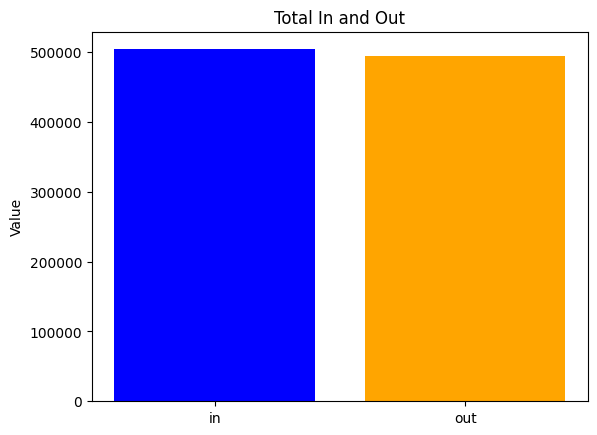

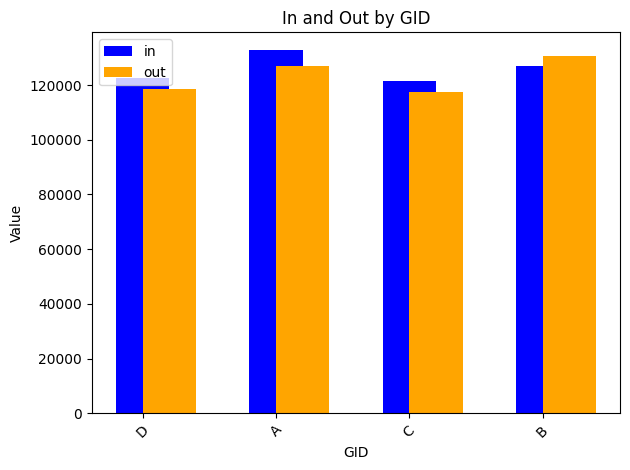

In [18]:
import polars as pl
import matplotlib.pyplot as plt

# 读取 Parquet 文件
file_path = "test_data.parquet"
df = pl.read_parquet(file_path)

# 检查字段
print("Columns:", df.columns)

# 1. 计算总 in 和 out
total_in_out = df.select([
    pl.col("in").sum().alias("total_in"),
    pl.col("out").sum().alias("total_out")
])
print("Total In and Out:\n", total_in_out)

# 2. 按 gid 分组统计
grouped_in_out = df.group_by("gid").agg([
    pl.col("in").sum().alias("sum_in"),
    pl.col("out").sum().alias("sum_out")
])
print("Grouped In and Out:\n", grouped_in_out)

# 3. 数据可视化 - 总 in 和 out
total_in_out_dict = total_in_out.to_dict(as_series=False)
plt.bar(["in", "out"], [total_in_out_dict["total_in"][0], total_in_out_dict["total_out"][0]], color=['blue', 'orange'])
plt.title("Total In and Out")
plt.ylabel("Value")
plt.show()

# 4. 数据可视化 - 按 GID 分组
grouped_dict = grouped_in_out.to_dict(as_series=False)
gids = grouped_dict["gid"]
sum_in = grouped_dict["sum_in"]
sum_out = grouped_dict["sum_out"]

x = range(len(gids))
plt.bar(x, sum_in, width=0.4, label='in', color='blue', align='center')
plt.bar(x, sum_out, width=0.4, label='out', color='orange', align='edge')
plt.xticks(x, gids, rotation=45)
plt.title("In and Out by GID")
plt.xlabel("GID")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


shape: (1, 10)
┌────────┬────────┬─────────┬───────────┬───┬─────────┬──────────┬────────────┬───────────┐
│ in_min ┆ in_max ┆ in_mean ┆ in_median ┆ … ┆ out_max ┆ out_mean ┆ out_median ┆ out_std   │
│ ---    ┆ ---    ┆ ---     ┆ ---       ┆   ┆ ---     ┆ ---      ┆ ---        ┆ ---       │
│ i32    ┆ i32    ┆ f64     ┆ f64       ┆   ┆ i32     ┆ f64      ┆ f64        ┆ f64       │
╞════════╪════════╪═════════╪═══════════╪═══╪═════════╪══════════╪════════════╪═══════════╡
│ 0      ┆ 998    ┆ 503.929 ┆ 505.0     ┆ … ┆ 997     ┆ 493.908  ┆ 500.0      ┆ 298.60317 │
└────────┴────────┴─────────┴───────────┴───┴─────────┴──────────┴────────────┴───────────┘


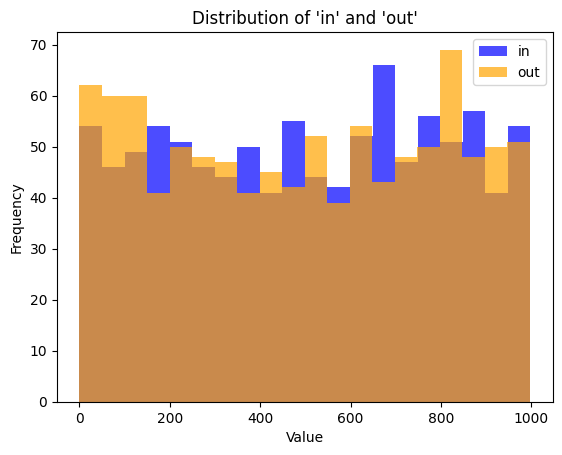

In [11]:
# 描述性统计
summary_stats = df.select([
    pl.col("in").min().alias("in_min"),
    pl.col("in").max().alias("in_max"),
    pl.col("in").mean().alias("in_mean"),
    pl.col("in").median().alias("in_median"),
    pl.col("in").std().alias("in_std"),
    pl.col("out").min().alias("out_min"),
    pl.col("out").max().alias("out_max"),
    pl.col("out").mean().alias("out_mean"),
    pl.col("out").median().alias("out_median"),
    pl.col("out").std().alias("out_std"),
])
print(summary_stats)


import matplotlib.pyplot as plt

# 可视化 in 的分布
plt.hist(df["in"].to_list(), bins=20, color='blue', alpha=0.7, label='in')
plt.hist(df["out"].to_list(), bins=20, color='orange', alpha=0.7, label='out')
plt.title("Distribution of 'in' and 'out'")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [12]:
# 极差计算
range_stats = df.select([
    (pl.col("in").max() - pl.col("in").min()).alias("in_range"),
    (pl.col("out").max() - pl.col("out").min()).alias("out_range")
])
print(range_stats)


shape: (1, 2)
┌──────────┬───────────┐
│ in_range ┆ out_range │
│ ---      ┆ ---       │
│ i32      ┆ i32       │
╞══════════╪═══════════╡
│ 998      ┆ 997       │
└──────────┴───────────┘


In [13]:
# 计算皮尔逊相关系数
correlation = df.select([
    pl.pearson_corr("in", "out").alias("in_out_correlation")
])
print(correlation)


AttributeError: module 'polars' has no attribute 'pearson_corr'

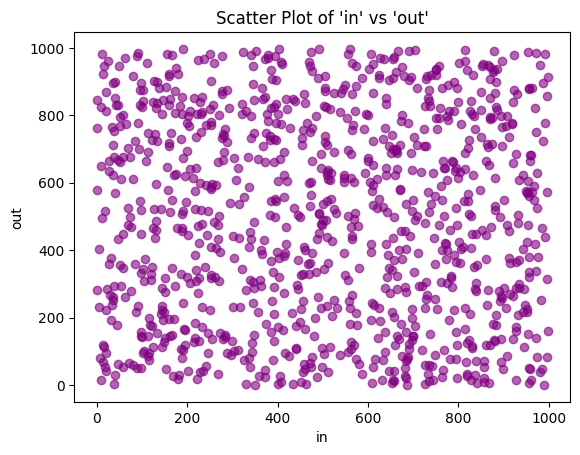

In [14]:
# 散点图显示 in 和 out 的相关性
plt.scatter(df["in"].to_list(), df["out"].to_list(), alpha=0.6, color='purple')
plt.title("Scatter Plot of 'in' vs 'out'")
plt.xlabel("in")
plt.ylabel("out")
plt.show()


In [15]:
# 分组统计
grouped_stats = df.groupby("gid").agg([
    pl.mean("in").alias("mean_in"),
    pl.std("in").alias("std_in"),
    pl.mean("out").alias("mean_out"),
    pl.std("out").alias("std_out"),
])
print(grouped_stats)


AttributeError: 'DataFrame' object has no attribute 'groupby'

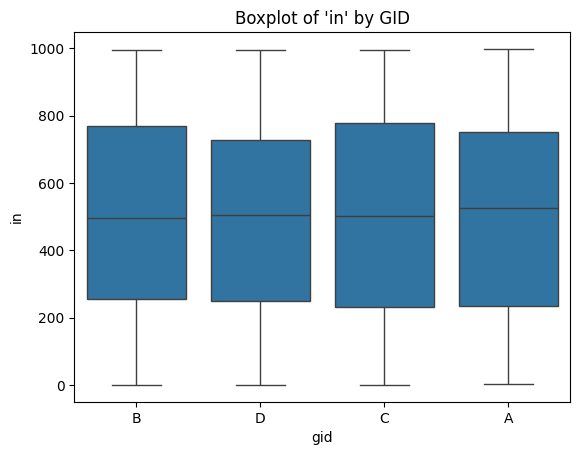

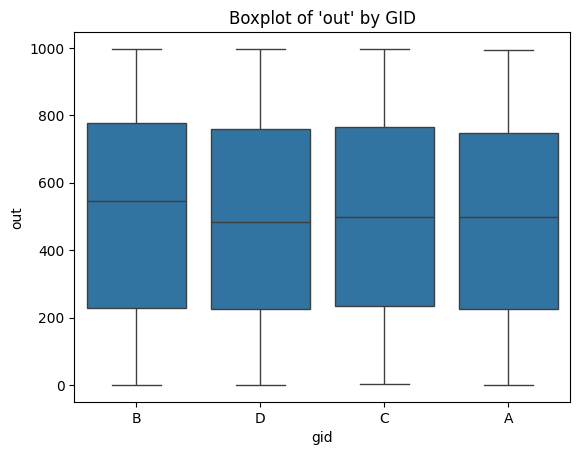

In [16]:
import seaborn as sns

# 转换数据为 pandas 格式以便 seaborn 处理
df_pandas = df.to_pandas()

# 绘制箱线图
sns.boxplot(x="gid", y="in", data=df_pandas)
plt.title("Boxplot of 'in' by GID")
plt.show()

sns.boxplot(x="gid", y="out", data=df_pandas)
plt.title("Boxplot of 'out' by GID")
plt.show()


In [17]:
# 保存分组统计为 CSV
grouped_stats.write_csv("grouped_stats.csv")

# 导出总的描述性统计
summary_stats.write_csv("summary_stats.csv")


NameError: name 'grouped_stats' is not defined